In [1]:
# TODO
   ## 1) Training :3
  ## 2) add function to check if the centroids keep moving 

In [2]:
%pylab inline
from scipy.linalg import norm, pinv
import numpy as np
import math
random.seed()

Populating the interactive namespace from numpy and matplotlib


In [15]:
# Usage: data = dbmoon(N, d, r, w)
# doublemoon.m - genereate the double moon data set in Haykin's book titled
# "neural networks and learning machine" third edition 2009 Pearson
# Figure 1.8 pp.61
# The data set contains two regions A and B representing 2 classes
# each region is a half ring with radius r = 10, width = 6, one is upper
# half and the other is lower half
# d: distance between the two regions
# will generate region A centered at (0, 0) and region B is a mirror image
# of region A (w.r.t.x axis) with a (r, d) shift of origin
# N:  # of samples each class, default = 1000
# d: seperation of two class, negative value means overlapping (default=1)
# r: radius (default=10), w: width of ring (default=6)
def dbmoon(N=1000, d=1, r=10, w=6):
    # clear all; close all;
    # generate region A:
    # first generate a uniformly random distributed data points from (-r-w / 2, 0)
    # to (r+w / 2, r+w / 2)
    N1 = 10 * N  # generate more points and select those meet criteria
    w2 = w / 2
    done = 0
    tmp1 = np.array([[]])
    while not done:
        tmp = np.array(2 * (r + w2) * (np.random.uniform(0, 1, (N1, 1)) - 0.5))
        tmp = np.column_stack((tmp, (r + w2) * np.random.uniform(0, 1, (N1, 1))))
        # 3rd column of tmp is the magnitude of each data point
        thirdCol = np.sqrt(np.multiply(tmp[:, 0], tmp[:, 0]) + np.multiply(tmp[:, 1], tmp[:, 1]))
        tmp = np.column_stack((tmp, thirdCol.T))
        idx = np.nonzero(np.logical_and((tmp[:, 2] > (r - w2)), (tmp[:, 2] < (r + w2))))
        if tmp1.shape == (1, 0):
            tmp1 = tmp[:, 0:2][idx]
        else:
            tmp1 = np.row_stack((tmp1, tmp[:, 0:2][idx]))
        if len(idx[0]) >= N:
            done = 1
            # if not enough data point, generate more and test

    # region A data and class label 0
    # region B data is region A data flip y coordinate - d, and x coordinate +r
    data = np.column_stack((tmp1[0:N, :], np.zeros((N, 1))))
    data1 = np.column_stack(((tmp1[0:N, 0] + r), (-tmp1[0:N, 1] - d), np.ones((N, 1))))
    data = np.row_stack((data, data1))
    #plot(data(1:N, 1), data(1:N, 2), '.r', data(N+1:end, 1), data(N+1:end, 2), '.b');
    # title(['Fig. 1.8 Double moon data set, d = ' num2str(d)]),
    # axis([-r-w2 2 * r+w2 -r-w2-d r+w2])
    return data

In [16]:
N=1000
dbmoon = dbmoon(N)
st=0
errorstack=zeros((4,2))

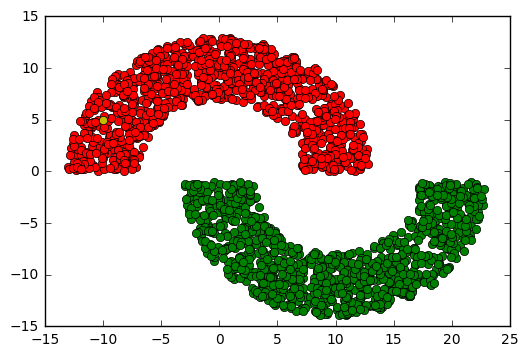

In [17]:
plot(dbmoon[0:N,0], dbmoon[0:N,1], 'ro',dbmoon[N:,0], dbmoon[N:,1], 'go',-10,5,'yo')
show()

In [40]:
def create_clusters(x,clusterskpoints):
    clusters={}
    a=[]
    for i in enumerate(x):
        mindistk=0
        mindist=100000000
        for j in enumerate(clusterskpoints):
            distance= norm(i[1]-j[1])
            if distance<mindist : 
                mindistk=j[0]
                mindist=distance   
        try:   
            a=clusters[mindistk]
            a = vstack((a,i[1]))
            clusters[mindistk] =a
        except KeyError:
            clusters[mindistk] = i[1]
    return clusters
def recenter(clusters):
    newmu = np.empty((0,2), int)
    keys = sorted(clusters.keys())
    
    for k in keys:
        n= np.mean(clusters[k], axis = 0)
        newmu=vstack((newmu,n))
    return newmu
def k_means(k):
    centers=10*np.random.randn(k, 2)-5
    for i in range(30):#should be untill convergence but 50 itteration has shown good results i.e is enough
        clusters=create_clusters(dbmoon[:,:2],centers)
        centers=recenter(clusters)
        #if i%30 == 0 :
    keys = sorted(clusters.keys())  
    for K in keys:
        plot(clusters[K][:N,:1],clusters[K][:N,1:2],'o')
        plot(centers[0:2*N,0], centers[0:2*N,1], 'yo')
    #print " iteration number :" , i
        #print " "
    show()
    return clusters,centers

In [41]:
def generate_w(k):
    return random.randn(k,1)
def error(d,o):
    return d-o
def sumerror(d,o):
    return 0.5*sum((error(d,o)**2))
def get_dmax(clusterskpoints):
    d= []
    for i in enumerate(clusterskpoints):
        for j in enumerate(clusterskpoints):
            d.append(norm(i[1]-j[1]))
    return max(d)

def net(x,center):
    net= (norm((x-center),axis=1).reshape(len(x),1)**2)
    return net
def gaussian_unit(x,variance,center):
    n  = x-center
    ne = norm(n,axis=1).reshape(len(center),1)
    return exp((-1*ne)/(2*variance))

def train(in_data):
    st=0
    for k in (2,4,6,8):
        x=in_data[0:2*N,0:2]
        d=in_data[0:2*N,2].reshape(2*N,1)
        eta=0.0001
        clusters,centers=k_means(k)
        #centers=np.array([[  6.87537075  , 6.33799326],[  3.62401967  ,-7.68839757],[ -6.37598033 ,  6.68839757],[ 16.87537075 , -7.33799326]])
        k_old=k
        k=len(centers)
        w=generate_w(k)
        #w=np.array([[ 0.77046837],[ 1.27188444],[ 0.69082246],[-0.23771142]])
        dmax= get_dmax(centers)
        variance = (dmax)/sqrt(2*k)
        variance=20.
        print "kmeans done"
        print "clusters number :",k
        print "training..."
        for j in range(500):
            if j==250:
                print "still training half way to end :D .."
            e=0
            total=0
            for i in range(2000):
                delta=0
                distance  = x[i]-centers
                net = norm(distance,axis=1).reshape(k,1)
                activation= np.exp(-(net**2)/(2*(variance**2))) 
                y=sum(activation*w)

                e=(error(d[i],y))
                ### update parameters 
                delta =(eta*e*activation)
                deltam=eta*e*w*activation*(-1/2.*(activation**2))
                w+=delta
                centers+=deltam
        total=0.
        for i in range(2000):
            e=0.
            delta=0.
            distance  = x[i]-centers
            net = norm(distance,axis=1).reshape(k,1)
            activation= np.exp(-(net**2)/(2*(variance**2))) 
            y=sum(activation*w)
            e=(error(d[i],y))**2
            total=total+e
        print "error :" , (total/(2*N))
        errorstack[st]=[k,(total/(2*N))]
        st=(st+1)
    mink=0
    minerror=10000    
    for i in range(len(errorstack)):
        if errorstack[i,1]<minerror:
            minerror=errorstack[i,1]
            mink=errorstack[i,0]
    print "minimum error", minerror ," with k :" , mink

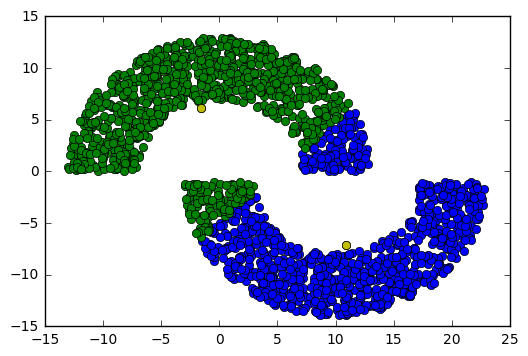

kmeans done
clusters number : 2
training...
still training half way to end :D ..
error : [ 0.06379034]


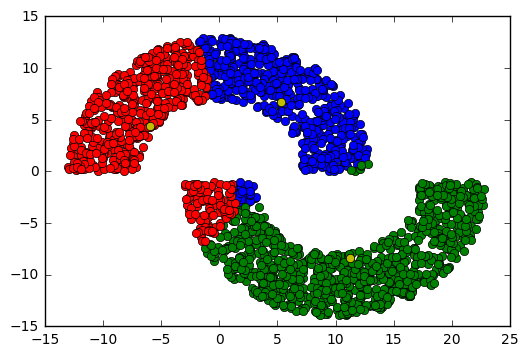

kmeans done
clusters number : 3
training...
still training half way to end :D ..
error : [ 0.05288057]


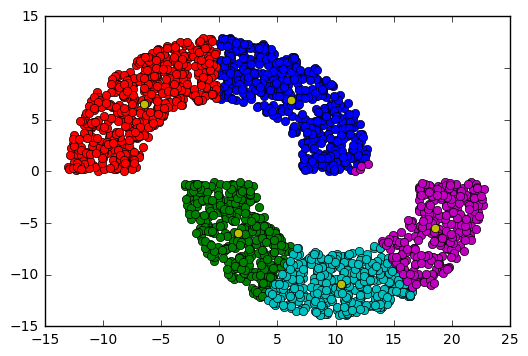

kmeans done
clusters number : 5
training...
still training half way to end :D ..
error : [ 0.04657926]


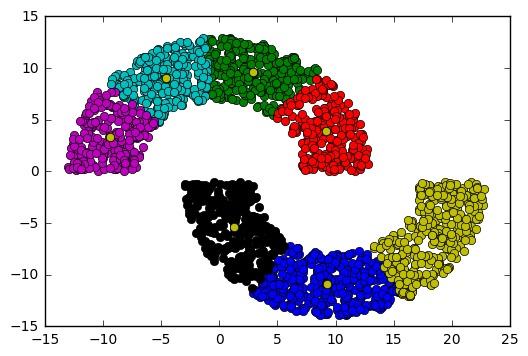

kmeans done
clusters number : 7
training...
still training half way to end :D ..
error : [ 0.04285444]
minimum error 0.0428544416092  with k : 7.0


In [42]:
train(dbmoon)
